In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16

from readdata import get_data
from tpcplot import draw_g4xyz
from tracklen import process_track, plot_dedx
from recoclusters import digits_to_clusters, pixid2position, pixid2binxy, binxy2xy

In [2]:
data_path = '/media/vitaly/4759e668-4a2d-4997-8dd2-eb4d25313d90/vitaly/CTau/tpcdigidata'
# data_path = 'data'

In [3]:
import glob

In [4]:
def get_keys(files):
    return sorted(list(set(['_'.join(os.path.splitext(os.path.split(item)[-1])[0].split('_')[2:4])
               for item in files])))

In [5]:
files = sorted(glob.glob(f'{data_path}/*.npy'))
keys = get_keys(files)
', '.join(keys)

'K_100.0, K_150.0, K_1500.0, K_200.0, K_250.0, K_300.0, K_400.0, K_500.0, K_600.0, e_100.0, e_150.0, e_1500.0, e_200.0, e_250.0, e_300.0, e_400.0, e_500.0, e_600.0, mu_100.0, mu_150.0, mu_1500.0, mu_200.0, mu_250.0, mu_300.0, mu_400.0, mu_500.0, mu_600.0, p_100.0, p_150.0, p_1500.0, p_200.0, p_250.0, p_300.0, p_400.0, p_500.0, p_600.0, pi_100.0, pi_150.0, pi_1500.0, pi_200.0, pi_250.0, pi_300.0, pi_400.0, pi_500.0, pi_600.0'

In [6]:
%%time
pg4, pdigi = get_data('K_400.0', data_path, 1000)

CPU times: user 18.5 s, sys: 981 ms, total: 19.5 s
Wall time: 20.2 s


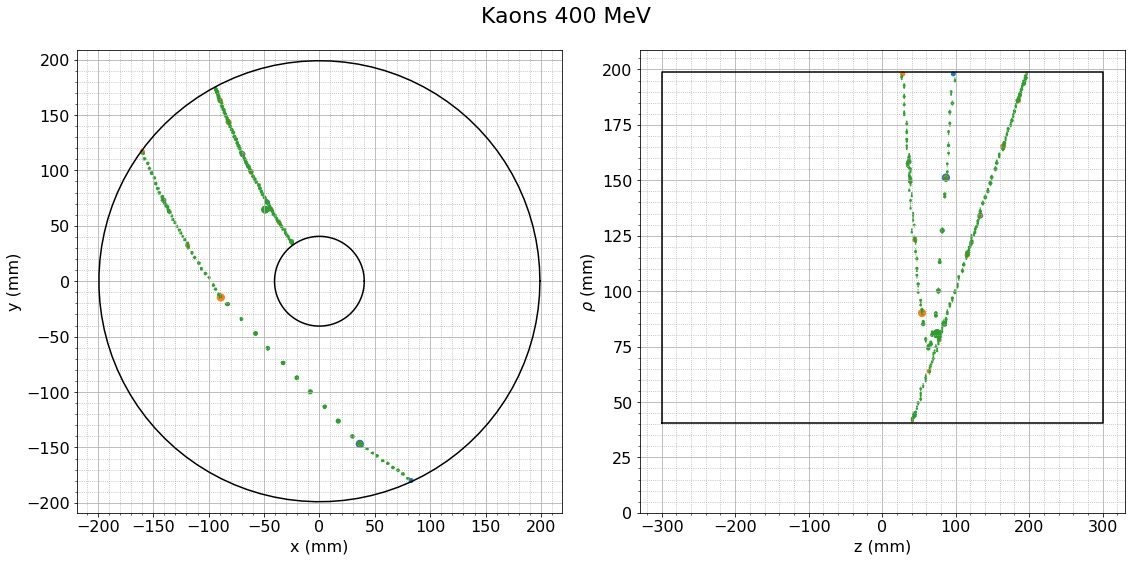

In [14]:
# nevt = 982, 11  # !!!
nevt = 11
draw_g4xyz(pg4[nevt], pdigi[nevt], f'Kaons 400 MeV')

In [17]:
pdigi[nevt].dtype

dtype([('evtn', '<i8'), ('channel', '<i8'), ('ampl', '<f8'), ('frame', '<i8')])

In [23]:
perm = np.argsort(pdigi[nevt]['frame'])
clus = pdigi[nevt][perm]

In [24]:
xbin, ybin = pixid2binxy(clus['channel'])

In [117]:
xyz = np.vstack((xbin, ybin, clus['frame'] // 50, clus['ampl'])).T
xyz[:10]

array([[8.70000000e+01, 2.00000000e+01, 5.90000000e+01, 7.41118627e+03],
       [8.80000000e+01, 2.00000000e+01, 5.90000000e+01, 9.98398662e+03],
       [8.70000000e+01, 2.10000000e+01, 5.90000000e+01, 6.93196374e+03],
       [8.80000000e+01, 2.10000000e+01, 5.90000000e+01, 4.50258122e+03],
       [8.90000000e+01, 2.30000000e+01, 6.00000000e+01, 3.30225151e+03],
       [8.80000000e+01, 2.30000000e+01, 6.00000000e+01, 9.70536209e+03],
       [8.90000000e+01, 2.20000000e+01, 6.00000000e+01, 4.08980766e+04],
       [8.70000000e+01, 2.20000000e+01, 6.00000000e+01, 1.75093162e+04],
       [8.80000000e+01, 2.20000000e+01, 6.00000000e+01, 5.14750797e+05],
       [8.80000000e+01, 2.00000000e+01, 6.00000000e+01, 1.11043938e+04]])

In [118]:
xyz[-10:]

array([[3.50000000e+01, 7.30000000e+01, 1.56000000e+02, 1.02562765e+04],
       [3.40000000e+01, 7.40000000e+01, 1.56000000e+02, 2.33730881e+05],
       [3.60000000e+01, 7.80000000e+01, 1.56000000e+02, 4.43558460e+03],
       [3.70000000e+01, 7.70000000e+01, 1.56000000e+02, 2.61293724e+05],
       [3.70000000e+01, 8.10000000e+01, 1.56000000e+02, 3.66808768e+03],
       [3.80000000e+01, 8.00000000e+01, 1.56000000e+02, 1.10363255e+04],
       [3.30000000e+01, 7.00000000e+01, 1.58000000e+02, 2.46151974e+05],
       [3.40000000e+01, 7.00000000e+01, 1.58000000e+02, 4.15044012e+04],
       [3.40000000e+01, 6.90000000e+01, 1.58000000e+02, 1.22273051e+04],
       [3.30000000e+01, 6.90000000e+01, 1.58000000e+02, 7.22983424e+04]])

In [119]:
def zsplit(xyz):
    zmap = {}
    for row in xyz:
        if row[2] in zmap:
            zmap[row[2]][(row[0], row[1])] = row[-1]
        else:
            zmap[row[2]] = {(row[0], row[1]) : row[-1]}
    return zmap

In [120]:
zmap = zsplit(xyz)
zmap[xyz[59][2]]

{(92.0, 30.0): 36396.297029933,
 (91.0, 30.0): 630570.9031397594,
 (90.0, 30.0): 16442.56876071769,
 (91.0, 31.0): 2904.878581369896,
 (91.0, 29.0): 209980.74721480213,
 (90.0, 29.0): 21292.011926654453,
 (91.0, 28.0): 1143.9308173637867,
 (92.0, 29.0): 1079.8388688808554}

In [121]:
def pix_neibs(xy):
    return [(xy[0] + 1, xy[1]), (xy[0] - 1, xy[1]), (xy[0], xy[1] + 1), (xy[0], xy[1] - 1)]

In [122]:
def connected_components(xya):
    ccs = []
    visited = set()
    for pix in xya.keys():
        if pix in visited:
            continue
        st = [pix]
        ccs.append([])
        while st:
            curpix = st.pop()
            if curpix in visited:
                continue
            ccs[-1].append([curpix[0], curpix[1], xya[curpix]])
            visited.add(curpix)
            for neib in pix_neibs(curpix):
                if neib in xya and neib not in visited:
                    st.append(neib)
    return ccs

In [123]:
clusters = []
clumap = {}
for z, xya in zmap.items():
    ccs = connected_components(xya)
    ccs = list(map(np.array, ccs))
    print(f'{z}: {len(ccs)}', end=' ')
    clumap[z] = ccs
    for cc in ccs:
        clusters.append([z, *cc])
clumap[154]

59.0: 1 60.0: 1 61.0: 1 62.0: 1 63.0: 1 64.0: 1 65.0: 1 66.0: 1 67.0: 1 68.0: 1 69.0: 1 70.0: 1 71.0: 1 72.0: 1 74.0: 1 75.0: 1 76.0: 1 77.0: 1 78.0: 1 81.0: 1 83.0: 1 84.0: 1 87.0: 1 88.0: 1 90.0: 1 92.0: 1 94.0: 1 96.0: 1 97.0: 1 98.0: 1 99.0: 1 100.0: 1 101.0: 1 102.0: 1 103.0: 1 104.0: 1 105.0: 1 106.0: 1 107.0: 1 109.0: 1 110.0: 1 113.0: 1 114.0: 1 116.0: 2 118.0: 2 119.0: 1 120.0: 3 121.0: 3 122.0: 3 123.0: 2 124.0: 3 125.0: 1 126.0: 2 127.0: 1 128.0: 2 129.0: 2 130.0: 2 131.0: 3 132.0: 2 133.0: 1 134.0: 2 135.0: 2 136.0: 1 137.0: 1 139.0: 2 141.0: 3 142.0: 1 143.0: 3 145.0: 3 146.0: 4 147.0: 3 148.0: 3 149.0: 2 150.0: 4 151.0: 5 152.0: 4 153.0: 1 154.0: 5 156.0: 4 158.0: 1 

[array([[4.50000000e+01, 9.60000000e+01, 1.03303683e+05],
        [4.50000000e+01, 9.70000000e+01, 3.86005104e+03],
        [4.40000000e+01, 9.70000000e+01, 1.08825699e+04],
        [4.40000000e+01, 9.60000000e+01, 2.99447656e+05]]),
 array([[4.20000000e+01, 8.90000000e+01, 1.16694837e+04],
        [4.20000000e+01, 8.80000000e+01, 2.56936961e+05],
        [4.10000000e+01, 8.80000000e+01, 4.16571904e+04],
        [4.10000000e+01, 8.90000000e+01, 2.20328190e+03]]),
 array([[4.20000000e+01, 9.30000000e+01, 1.58103354e+04],
        [4.20000000e+01, 9.20000000e+01, 2.34334832e+04],
        [4.30000000e+01, 9.20000000e+01, 2.01428977e+05],
        [4.30000000e+01, 9.30000000e+01, 1.36338092e+05]]),
 array([[4.50000000e+01, 9.90000000e+01, 1.30191841e+05],
        [4.50000000e+01, 1.00000000e+02, 5.51382780e+04],
        [4.60000000e+01, 1.00000000e+02, 3.96361331e+04],
        [4.60000000e+01, 9.90000000e+01, 9.42875097e+04]]),
 array([[4.90000000e+01, 1.07000000e+02, 1.12719037e+03],
      

In [124]:
def cluster_center(cc):
    return cc[:, :2].T @ cc[:, -1] / cc[:, -1].sum()

In [125]:
def plot_components(ccs):
    plt.figure(figsize=(6, 6))
    for cc in ccs:
        plt.scatter(cc[:, 0], cc[:, 1])
        cnt = cluster_center(cc)
        plt.scatter([cnt[0]], [cnt[1]])
    plt.axis('equal')
    plt.grid()
    plt.tight_layout()

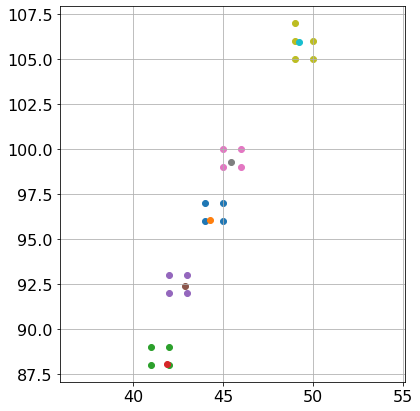

In [126]:
plot_components(clumap[154])

In [129]:
def ccs2clusters(ccs, z):
    return [[*cluster_center(cc), z, np.sum(cc[:, 2])] for cc in ccs]

In [131]:
clu154 = ccs2clusters(clumap[154], 154 * 50.)
clu154

[[44.25668331644401, 96.03531217780369, 7700.0, 417493.9605465349],
 [41.85963162825702, 88.04439755013678, 7700.0, 312466.91686295794],
 [42.89590799654274, 92.40356507583289, 7700.0, 377010.88692646957],
 [45.41948963146313, 99.29686231608079, 7700.0, 319253.76151876815],
 [49.19631035754712, 105.9857148400735, 7700.0, 177172.4450663329]]

In [133]:
clusters = np.vstack([ccs2clusters(ccs, z) for z, ccs in clumap.items()])
clusters.shape

(132, 4)

In [134]:
clusters[:10]

array([[8.75024873e+01, 2.03966235e+01, 5.90000000e+01, 2.88297179e+04],
       [8.80403075e+01, 2.18040333e+01, 6.00000000e+01, 7.31398846e+05],
       [8.86794461e+01, 2.31909504e+01, 6.10000000e+01, 7.77751985e+05],
       [8.89811858e+01, 2.36130165e+01, 6.20000000e+01, 6.55280948e+05],
       [8.95192757e+01, 2.52871428e+01, 6.30000000e+01, 4.18543818e+05],
       [8.99898843e+01, 2.70392640e+01, 6.40000000e+01, 4.57854184e+05],
       [9.02740430e+01, 2.83065303e+01, 6.50000000e+01, 6.44339767e+05],
       [9.09997190e+01, 2.97480618e+01, 6.60000000e+01, 9.19811176e+05],
       [9.10716090e+01, 3.01770772e+01, 6.70000000e+01, 3.82262563e+05],
       [9.21921866e+01, 3.18374799e+01, 6.80000000e+01, 3.01426687e+05]])

In [135]:
np.savetxt('event.txt', clusters)